In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")
from fastai.vision import *
from torch import nn
from collections import defaultdict
from torch.utils.data import SequentialSampler
from fastai3D import mysampler
#from fastai3D import functions
#from fastai3D import loader #does not comply 

In [3]:
#path = Path('/home/suze/Documents/Thesis/seed_images/Data_for_ML_Test/train') #suze_device
path = Path('/home/suze/seed_images/Data_for_ML_Test//test_model/Belinda_test')
path.ls()

[PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/NewLabels'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/Images'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/models'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/valid.txt')]

In [4]:
path_img = path/'Images' #should later be provided through ini file
#path_lbl = path/'Labels' #should later be provided through ini file #suze_device
path_lbl = path/'NewLabels' #should later be provided through ini file

In [5]:
img_names=get_image_files(path_img)
img_names[:3]

[PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/Images/BM1_0833.tif'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/Images/BM1_1200.tif'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/Images/BM1_1944.tif')]

In [6]:
lbl_names=get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/NewLabels/BM1_0833.tif'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/NewLabels/BM1_1200.tif'),
 PosixPath('/home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test/NewLabels/BM1_1944.tif')]

In [7]:
def get_mask(img):
    return (path_lbl)/img.name

In [8]:
#def get_mask(x):
#    return PosixPath(str(x)
#            .replace('train','NewLabels')
#            .replace('valid','NewLabels'))
            #.replace('resampled', 'labels'))

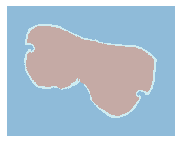

In [9]:
mask = open_mask(get_mask(img_names[0]))
mask.show()

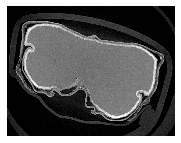

In [10]:
img = open_image(img_names[0])
img.show()

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([668, 864]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [12]:
def filter_background(img_list):
    include=[]
    for img in img_list:
        mask = open_mask(get_mask(img))
        count_total=(torch.unique(mask.data, return_counts=True))
        if not count_total[0].tolist() == [0]:
            include.append(img)
    return include

"""function to filter out images that only contain background; used to filter in the API; 
function has to return a boolean
slow, every mask has to be opened to check the values"""
def check_back(img):
    mask = open_mask(get_mask(img))
    count_total=(torch.unique(mask.data, return_counts=True))
    if not count_total[0].tolist() == [0]:
        return True
    else:
        return False

def count_mask(img_list):
    img_list = filter_background(img_list)
    count_classes = defaultdict(int)
    for img in img_list:
        #return the occurence of every class in the mask for an image
        mask = open_mask(get_mask(img))
        count_total = torch.unique(mask.data, return_counts=True)
        classes=count_total[0].tolist()
        count_real=count_total[1].tolist()
        for x, y in zip(classes, count_real):
            count_classes[x] += y
    return count_classes

def acc_seeds(input, target):
    target = target.squeeze(1)
    mask = target != 0 #not interested in background
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [13]:
%time classes_count = count_mask(img_names)
classes_count
#slow for big sets, make faster?

CPU times: user 32min 51s, sys: 2min 7s, total: 34min 59s
Wall time: 1min 5s


defaultdict(int, {0: 796196338, 1: 240902526, 2: 25500623, 3: 21869121})

In [14]:
#append occurences in a list 
#seems redundant
counts = []
for c in classes_count:
    counts.append(classes_count[c])
counts

[796196338, 240902526, 25500623, 21869121]

In [15]:
weight_ratios =[min(counts)/x for x in counts]
weight_ratios

[0.02746699520740574, 0.09077995720144504, 0.8575916360945378, 1.0]

In [16]:
src = (SegmentationItemList.from_folder(path)
       #.split_subsets(train_size=0.2, valid_size=0.1)
       .filter_by_func(check_back)
       .split_by_fname_file('valid.txt')
       .label_from_func(get_mask, classes=list(range(4))))

In [17]:
data = (src.transform(get_transforms(), tfm_y=True, size=128)
       .databunch(bs=1)
       .normalize())
#data.show_batch(4, figsize=(10,7))
data.batch_size

1

In [18]:
#data.show_batch(4)

In [19]:
data.train_dl = data.train_dl.new(shuffle=False, drop_last=False, sampler=None, batch_sampler=mysampler.OrderedBatchSampler(SequentialSampler(data.train_dl), 3, True))

In [20]:
data

ImageDataBunch;

Train: LabelList (1758 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: /home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test;

Valid: LabelList (2000 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: /home/suze/seed_images/Data_for_ML_Test/test_model/Belinda_test;

Test: None

In [21]:
#data
print(data.batch_size)

None


In [22]:
#data.show_batch(4, figsize=(10,7))

In [23]:
#from Nikos

def acc_seeds(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

In [24]:
metrics=acc_seeds
wd=1e-2

In [25]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [26]:
#set class weights
class_weights=torch.FloatTensor(weight_ratios)
learn.crit = nn.CrossEntropyLoss(weight=class_weights)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


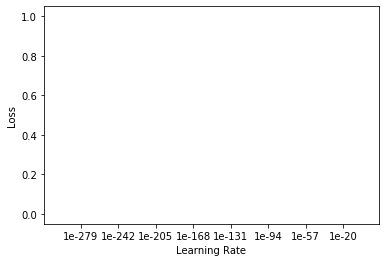

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(cyc_len=4, max_lr=3e-5)

epoch,train_loss,valid_loss,acc_seeds,time
0,1.399353,5.989475,0.369973,00:52
1,0.179327,7.707029,0.376137,00:51
2,0.095277,4.366419,0.433889,00:52
3,0.072892,4.256054,0.435903,00:56


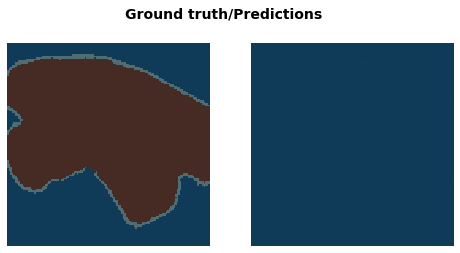

In [29]:
learn.show_results()

In [ ]:
learn.freeze()

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(3e-5/100, 3e-5)

In [ ]:
learn.fit_one_cycle(4, lrs)

In [30]:
from fastai.vision.interpret import *
interp = SegmentationInterpretation.from_learner(learn)

In [31]:
top_losses, top_idxs = interp.top_losses(sizes=(128,128))

In [32]:
mean_cm, single_img_cm = interp._generate_confusion()

label,score
0.0,0.996916
1.0,0.386072
2.0,0.333145
3.0,0.278960


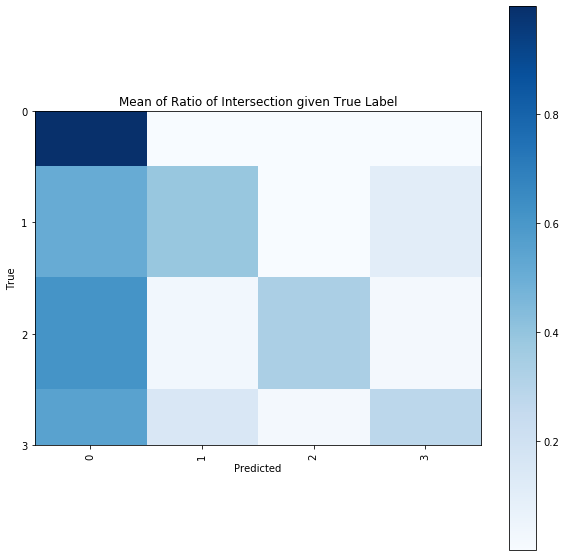

In [33]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")